In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [21]:
#%%
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_lib import sweep_regressors, transform_features2Xdict, RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

In [4]:
device = "cuda" if th.cuda.is_available() else "cpu"
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
imgdir_shared = join(stimuli_root, "shared1000")
imgdir = join(stimuli_root, "stimuli_pilot_20241119/results")
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
# data_path = join(ephys_root, "nsd_shared1000_6monkeys_2024.h5")

# Load data
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

subjects: ['red_20241212-20241220']


In [7]:
figdir = join(dataroot, subject_id, "model_outputs_test_std")
os.makedirs(figdir, exist_ok=True)

In [5]:
# for subject_id in ['paul_240713-240710', 
#                    'paul_20240713-20240710', 
#                    'red_20240713-20240710',
#                    'baby1_20240329-20240325', 
#                    'baby1_240329-240325', 
#                    'baby5_240819-240822', ]: 
# for subject_id in ['red_20241212-20241220', ]:
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [imgdir_shared, imgdir])
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, subject_id, "model_outputs_test")
os.makedirs(figdir, exist_ok=True)
    #%%
batch_size = 96
modelname = "resnet50_robust"
# for modelname in ["resnet50_clip", "resnet50_dino", "resnet50", "resnet50_robust", ]: # 
model, transforms_pipeline = load_model_transform(modelname, device=device)
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()
#%%
# %%


All stimulus files were found


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

.layer1.Bottleneck0 torch.Size([1028, 256, 56, 56])
.layer1.Bottleneck1 torch.Size([1028, 256, 56, 56])
.layer1.Bottleneck2 torch.Size([1028, 256, 56, 56])
.layer2.Bottleneck0 torch.Size([1028, 512, 28, 28])
.layer2.Bottleneck1 torch.Size([1028, 512, 28, 28])
.layer2.Bottleneck2 torch.Size([1028, 512, 28, 28])
.layer2.Bottleneck3 torch.Size([1028, 512, 28, 28])
.layer3.Bottleneck0 torch.Size([1028, 1024, 14, 14])
.layer3.Bottleneck1 torch.Size([1028, 1024, 14, 14])
.layer3.Bottleneck2 torch.Size([1028, 1024, 14, 14])
.layer3.Bottleneck3 torch.Size([1028, 1024, 14, 14])
.layer3.Bottleneck4 torch.Size([1028, 1024, 14, 14])
.layer3.Bottleneck5 torch.Size([1028, 1024, 14, 14])
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# # Define RidgeCV model with cross-validation
# ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])

# # Use a pipeline to standardize before fitting
# model = make_pipeline(StandardScaler(), ridge_cv)
# model.fit(X_train, y_train)  # X_train should not be manually standardized

In [13]:
resp_mat_sel = resp_mat[:, :]
print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, 
                        dimred_list=["pca10", "pca25", "pca50",  "pca100", "pca250", "pca500", "pca1000","srp", "srp1000",],  #  "srp"
                        pretrained_Xtransforms={}, use_pca_dual=True, use_srp_torch=True)

Fitting models for All channels N=64
.layer1.Bottleneck0 torch.Size([1028, 256, 56, 56])
Time taken to transform .layer1.Bottleneck0 pca10 [1028, 10]: 2.309s
Time taken to transform .layer1.Bottleneck0 pca25 [1028, 25]: 2.319s
Time taken to transform .layer1.Bottleneck0 pca50 [1028, 50]: 2.339s
Time taken to transform .layer1.Bottleneck0 pca100 [1028, 100]: 2.446s
Time taken to transform .layer1.Bottleneck0 pca250 [1028, 250]: 2.693s
Time taken to transform .layer1.Bottleneck0 pca500 [1028, 500]: 3.099s
Time taken to transform .layer1.Bottleneck0 pca1000 [1028, 1000]: 3.950s
Time taken to transform .layer1.Bottleneck0 srp [1028, 5944]: 3.274s
Time taken to transform .layer1.Bottleneck0 srp1000 [1028, 1000]: 0.828s
Time taken to transform .layer1.Bottleneck0: 23.257s
.layer1.Bottleneck1 torch.Size([1028, 256, 56, 56])
Time taken to transform .layer1.Bottleneck1 pca10 [1028, 10]: 2.292s
Time taken to transform .layer1.Bottleneck1 pca25 [1028, 25]: 2.341s
Time taken to transform .layer1.B

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
regressors = [RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
              make_pipeline(StandardScaler(), 
                RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),)
            # MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            ] 
regressor_names = ["RidgeCV", "RidgeCV_standardized"]
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, 
                                                    verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

.layer1.Bottleneck0_pca10 RidgeCV D2_train: 0.033 D2_test: 0.012 time: 0.010
.layer1.Bottleneck0_pca10 RidgeCV_standardized D2_train: 0.033 D2_test: 0.010 time: 0.010
.layer1.Bottleneck0_pca25 RidgeCV D2_train: 0.052 D2_test: 0.033 time: 0.010
.layer1.Bottleneck0_pca25 RidgeCV_standardized D2_train: 0.047 D2_test: 0.030 time: 0.011
.layer1.Bottleneck0_pca50 RidgeCV D2_train: 0.090 D2_test: 0.042 time: 0.033
.layer1.Bottleneck0_pca50 RidgeCV_standardized D2_train: 0.091 D2_test: 0.038 time: 0.013
.layer1.Bottleneck0_pca100 RidgeCV D2_train: 0.104 D2_test: 0.035 time: 0.018
.layer1.Bottleneck0_pca100 RidgeCV_standardized D2_train: 0.126 D2_test: 0.017 time: 0.020
.layer1.Bottleneck0_pca250 RidgeCV D2_train: 0.164 D2_test: 0.035 time: 0.044
.layer1.Bottleneck0_pca250 RidgeCV_standardized D2_train: 0.234 D2_test: 0.018 time: 0.045
.layer1.Bottleneck0_pca500 RidgeCV D2_train: 0.232 D2_test: 0.036 time: 0.120
.layer1.Bottleneck0_pca500 RidgeCV_standardized D2_train: 0.339 D2_test: -0.000 tim

In [27]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_PCsweep_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_PCsweep_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_PCsweep_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
# %%
figh = plot_result_df_per_layer(result_df_lyrswp, )
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_PCsweep_synopisis", figh=figh)
# %%
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh)
    figh = plot_result_df_per_layer(result_df_masked, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_PCsweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")

In [17]:
result_df_formated = format_result_df(result_df_lyrswp, )
result_df_formated

,layer_dimred,regressor,alpha,train_score,test_score,n_feat,runtime,layer,dimred
0,.layer1.Bottleneck0_pca10,RidgeCV,"[100000.0, 100000.0, 100000.0, 100000.0, 10000...",0.032762,0.011695,10,0.010485,.layer1.Bottleneck0,pca10
1,.layer1.Bottleneck0_pca10,RidgeCV_standardized,NaN,0.033054,0.010435,10.0,0.009899,.layer1.Bottleneck0,pca10
2,.layer1.Bottleneck0_pca25,RidgeCV,"[100000.0, 100000.0, 100000.0, 1000000.0, 1000...",0.051573,0.032573,25,0.010193,.layer1.Bottleneck0,pca25
3,.layer1.Bottleneck0_pca25,RidgeCV_standardized,NaN,0.047253,0.029692,25.0,0.01088,.layer1.Bottleneck0,pca25
4,.layer1.Bottleneck0_pca50,RidgeCV,"[10000.0, 100000.0, 100000.0, 1000000.0, 10000...",0.089905,0.041532,50,0.033245,.layer1.Bottleneck0,pca50
...,...,...,...,...,...,...,...,...,...
283,.layer4.Bottleneck2_pca1000,RidgeCV_standardized,NaN,0.764783,-0.004413,1000.0,0.236938,.layer4.Bottleneck2,pca1000
284,.layer4.Bottleneck2_srp,RidgeCV,"[10000.0, 100000.0, 10000.0, 100000.0, 10000.0...",0.642313,0.371397,5944,0.283883,.layer4.Bottleneck2,srp
285,.layer4.Bottleneck2_srp,RidgeCV_standardized,NaN,0.646282,0.370628,5944.0,0.3368,.layer4.Bottleneck2,srp
286,.layer4.Bottleneck2_srp1000,RidgeCV,"[100000.0, 100000.0, 100000.0, 1000000.0, 1000...",0.533434,0.335618,1000,0.191033,.layer4.Bottleneck2,srp1000


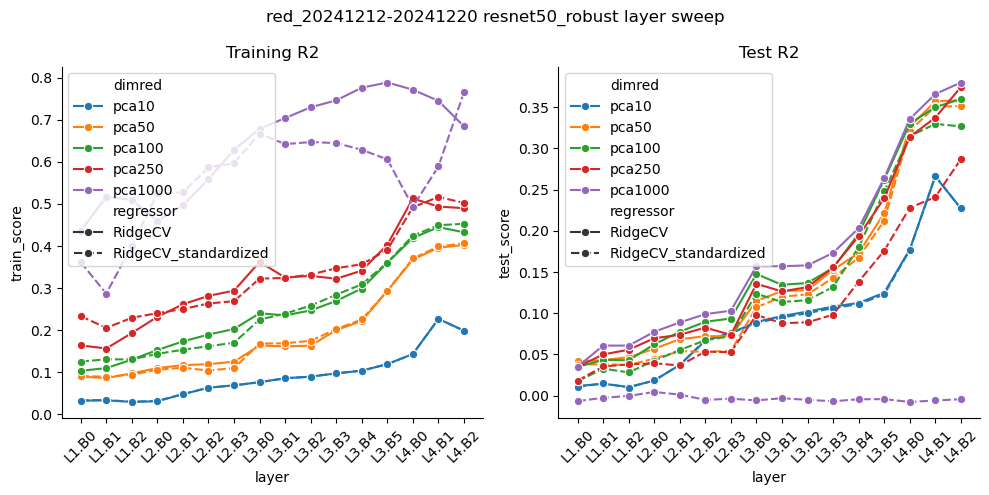

In [25]:
figh = plot_result_df_per_layer(result_df_formated.query("dimred in ['pca10', 'pca50', 'pca100', 'pca250', 'pca1000',]"), )
figh.suptitle(f"{subject_id} {modelname} layer sweep")
# Share y axis across subplots
# ylims = [min(ax.get_ylim()[0] for ax in figh.axes), max(ax.get_ylim()[1] for ax in figh.axes)]
# for ax in figh.axes:
#     ax.set_ylim(ylims)
figh.tight_layout()

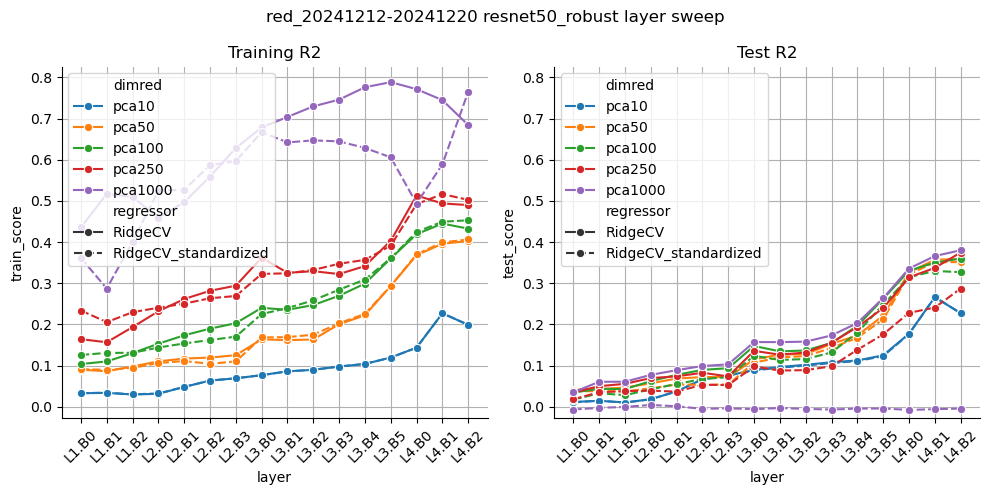

In [28]:
figh = plot_result_df_per_layer(result_df_formated.query("dimred in ['pca10', 'pca50', 'pca100', 'pca250', 'pca1000',]"), )
figh.suptitle(f"{subject_id} {modelname} layer sweep")
# Share y axis across subplots
ylims = [min(ax.get_ylim()[0] for ax in figh.axes), max(ax.get_ylim()[1] for ax in figh.axes)]
for ax in figh.axes:
    ax.set_ylim(ylims)
    ax.grid(True)
figh.tight_layout()

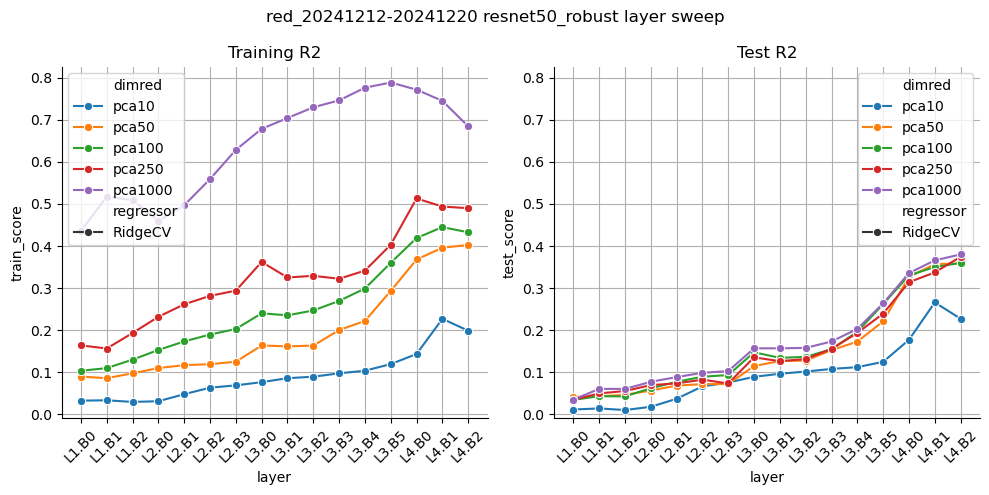

In [26]:
figh = plot_result_df_per_layer(result_df_formated.query("dimred in ['pca10', 'pca50', 'pca100', 'pca250', 'pca1000',] and regressor == 'RidgeCV'"), )
figh.suptitle(f"{subject_id} {modelname} layer sweep")
# Share y axis across subplots
ylims = [min(ax.get_ylim()[0] for ax in figh.axes), max(ax.get_ylim()[1] for ax in figh.axes)]
for ax in figh.axes:
    ax.set_ylim(ylims)
    ax.grid(True)
figh.tight_layout()

In [ ]:
# resp_mat_sel = resp_mat[:, :]
# print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
# # result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
# #             resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
# #             alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
# #             dimred_list=["pca1000", "srp", "srp1000",], verbose=True, use_pca_dual=True, use_srp_torch=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, 
#                         dimred_list=["pca1000", "srp", "srp1000",],  #  "srp"
#                         pretrained_Xtransforms={}, use_pca_dual=True, use_srp_torch=True)
regressors = [RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
              make_pipeline(StandardScaler(), 
                RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),)
            # MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            ] 
regressor_names = ["RidgeCV", "RidgeCV_standardized"]
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, 
                                                    verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))
# %%
figh = plot_result_df_per_layer(result_df_lyrswp, )
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# %%
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh)
    figh = plot_result_df_per_layer(result_df_masked, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")
